In [1]:
!which python


/Users/totucuong/miniconda3/envs/experiment/bin/python


In [2]:
!python --version

Python 3.6.0


In [3]:
from __future__ import print_function
import os
from collections import defaultdict
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate

smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

In [4]:
K=4
true_weight = torch.tensor([0.06, 0.4, 0.4, 0.04])
true_mu = torch.tensor([2., 20., 45., 60.])
true_scale= torch.tensor([10., 5., 1., 20.])
N= 100000

In [5]:
assignment = dist.Categorical(true_weight).expand_by([N])()
data = dist.Normal(true_mu[assignment], true_scale[assignment])()

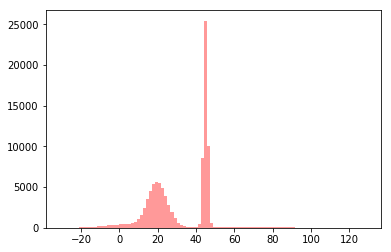

In [6]:
pyplot.hist(data, bins=100, alpha=0.4, color='r');

In [7]:
K = 4
def init_locs(data, K):
    cluster = MiniBatchKMeans(batch_size=100, n_clusters=K)
    cluster.fit(data.view(len(data), -1))
    return torch.tensor(cluster.cluster_centers_.squeeze()).type(torch.float32)

mus = init_locs(data, K)

def model(data):
    # Global parameters.
    weights = pyro.param('weights', torch.ones(K) / K, constraint=constraints.simplex)
    locs = pyro.param('locs', mus)
    scales = pyro.param('scales', 0.5 * torch.ones(K), constraint=constraints.positive)

    with pyro.iarange('data', len(data)) as ind:
        # Local variables.
        assignment = pyro.sample('assignment',
                                 dist.Categorical(weights).expand_by([len(ind)]))
        pyro.sample('obs', dist.Normal(locs[assignment], scales[assignment]), obs=data.index_select(0, ind))

@config_enumerate(default='parallel')
def guide(data):
    with pyro.iarange('data', len(data), subsample_size=10000) as ind:
        # Local parameters.
#         print('sampled index', ind)
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data), K) / K,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Categorical(assignment_probs[ind]))

In [8]:
optim = pyro.optim.Adam({'lr': 0.02, 'betas': [0.9, 0.99]})
inference = SVI(model, config_enumerate(guide, 'parallel'), optim,
                loss=TraceEnum_ELBO(max_iarange_nesting=1))

In [ ]:
pyro.set_rng_seed(1)      # Set seed to make results reproducible.
pyro.clear_param_store()  # Clear stale param values.

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
inference.loss(model, guide, data)  # Initializes param store.
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(5000 if not smoke_test else 2):
    loss = inference.step(data)
    losses.append(loss)
    if (i % 100 == 0):
        print('loss at {}th epoch is {}'.format(i, loss))

In [ ]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters, lr=0.001')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');
pyplot.savefig('elbo_svi_lr_0001.png')

In [ ]:
losses[-1]

In [ ]:
len(gradient_norms['locs'])

In [ ]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms[:1000], label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [ ]:
N

In [ ]:
weights = pyro.param('weights')
locs = pyro.param('locs')
scales = pyro.param('scales')
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scales = {}'.format(scales.data.numpy()))

In [ ]:
weights.sum()

In [ ]:
assignment = dist.Categorical(weights).expand_by([N])()
syn = dist.Normal(locs[assignment], scales[assignment])()

In [ ]:
pyplot.hist(syn.detach().numpy(), bins=100, alpha=0.2, color='b', label='synthetic');
pyplot.hist(data+10, bins=100, alpha=0.2, color='r', label='real right-shifted by 10');
pyplot.legend();

In [ ]:
true_weight,true_mu , true_scale

# Lesson learnt

1. The weights of components should be well-balanced. Otherwise it is very hard to capture all the modes.
2. The greater data variance is the large subsample size should be during training.